# Minimal analysis
---

#### Overview
Processes timelapse data from intrinsic imaging experiments on mice.

#### Outline
1. Process csv
2. ~~Drift alignment~~
3. ~~Bleah correction~~
4. ~~High-pass filtering~~
5. Frame averaging

#### Packages

In [1]:
from pathlib import Path

from natsort import natsorted
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, filters
from fancy_plot import fancy_plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Collect experimental data and process csv

In [29]:
def process_data(tif_paths, decimation_factor):

    if type(tif_paths) == str:
        tif_paths = [tif_paths]

    //continue
    stack = io.imread(tif_path)
    CROP_PX = 20
    BOTTOM_PERCENTILE = 5
    # crop image a little bit to remove the black border
    stack = stack[:, CROP_PX:-CROP_PX, CROP_PX:-CROP_PX]

    frames_base = np.arange(*np.round(np.array([100,2000])/decimation_factor), dtype=int)
    frames_stim = np.arange(*np.round(np.array([3600,8000])/decimation_factor), dtype=int)


    stack_base = stack[frames_base-1]
    stack_stim = stack[frames_stim-1]

    tproj_base = stack_base.mean(axis=0)
    tproj_stim = stack_stim.mean(axis=0)

    image_diff = (tproj_stim - tproj_base)

    stimstack_basesubtracted = stack_stim
    # find bottom X% of pixels in image
    bottom10 = np.percentile(stimstack_basesubtracted, BOTTOM_PERCENTILE, axis=(1,2), keepdims=True).astype(np.uint16)
    # subtract bottom X% from all pixels
    stimstack_basesubtracted -= bottom10
    stimstack_basesubtracted -= stimstack_basesubtracted.min(axis=0, keepdims=True)
    stimstack_basesubtracted[stimstack_basesubtracted > 30000] = 0

    # save tiff stack
    io.imsave(Path(tif_path).parent / ("processed_" + Path(tif_path).name), stimstack_basesubtracted)

    # images to plot
    images = {
        "Avg Base": tproj_base,
        "Avg Stim": tproj_stim,
        "Diff Image": filters.gaussian(image_diff, sigma=1.6)
    }

    # create figure
    ncols = len(images)
    fig, axes = plt.subplots(
        ncols=ncols,
        figsize=(4*ncols, 3)
    )
    for (title, image), ax in zip(images.items(), axes):
        ax.imshow(image)
        ax.set_title(title)
        # colorbar
        cbar = plt.colorbar(ax.imshow(image), ax=ax)

    roi = {
    "center": (200, 100),  # (x, y)
    "width": 100,
    "height": 200
    }

    # make a fancy plot
    # fancy_plot(
    #     stack,
    #     frames_base,
    #     frames_stim,
    #     images,
    #     roi,
    # )
    return image_diff

In [38]:
fp_tif = natsorted((dir_experiments/date/'Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1').glob("*.tif"))
fp_tif

[PosixPath('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1_MMStack_Pos0.ome.tif'),
 PosixPath('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1_MMStack_Pos0_1.ome.tif')]

/var/folders/zl/xwxf2dnn3tb1fb4jpx_lvlxc0000gn/T/ipykernel_94926/759450341.py:30: UserWarning: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30minLHL27mMhistinj_1pt25pctISO_1_1/processed_aligned_ZProject8_Zyla_30minLHL27mMhist_inj1pt25pctISO_1_1_MMStack_Pos0_1.ome.tif is a low contrast image
  io.imsave(Path(tif_path).parent / ("processed_" + Path(tif_path).name), stimstack_basesubtracted)


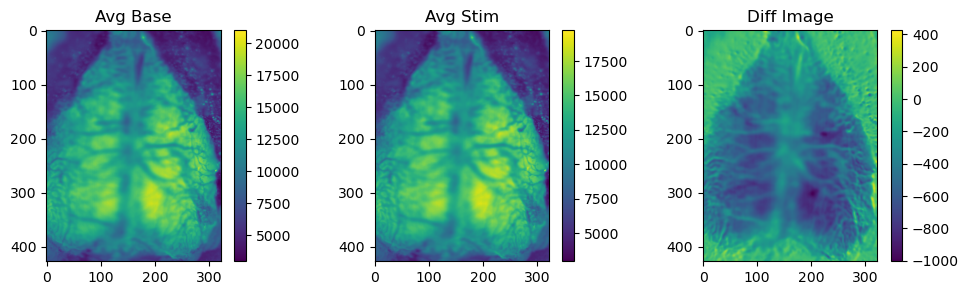

In [35]:
# location where all experimental data is kept
dir_experiments = Path("/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections")

# path to a particular (or set of) experiment(s) for analysis
date = "2024-03-06"
expt = 'Zyla_30minLHL27mMhistinj_1pt25pctISO_1_1' # 'RHL_hist' # "RHL_hist" # LHL_saline
# fp_csv = natsorted((dir_experiments/date/expt).glob("*.csv"))[0]
fp_tifs = natsorted((dir_experiments/date/expt).glob("aligned*.tif"))

decimation_factor = 8
img_d = process_data(fp_tif, decimation_factor)

# parse csv and show a preview
# df_daq = parse_csv(fp_csv)
# df_daq.head(8)

(0.0, 100.0)

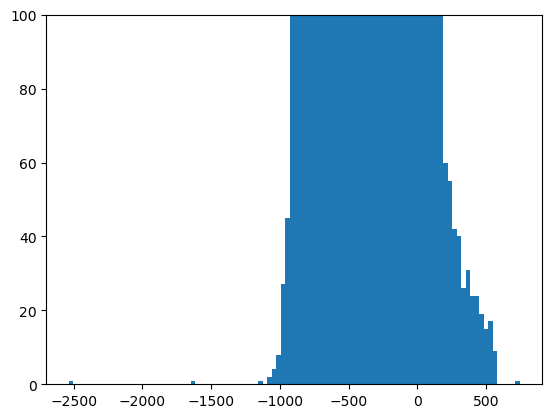

In [19]:
plt.hist(img_d.flatten(), bins=100)
plt.ylim(0, 100)

#### Process csv

#### Load timelapse

## Drift alignment

Work in progress...

## Bleach correction

Is this truly necessary?

## Temporal filtering (WIP)

* Oscillation artifact (probably breathing) is ~7 samples when sampled at 10 Hz (1.4 Hz)

In [8]:
stack.shape

(9000, 397, 388)

## Math

## Plotting

#### Simplest little plot ya ever did see

#### A little more sophisticato

In [27]:
from fancy_plot import fancy_plot

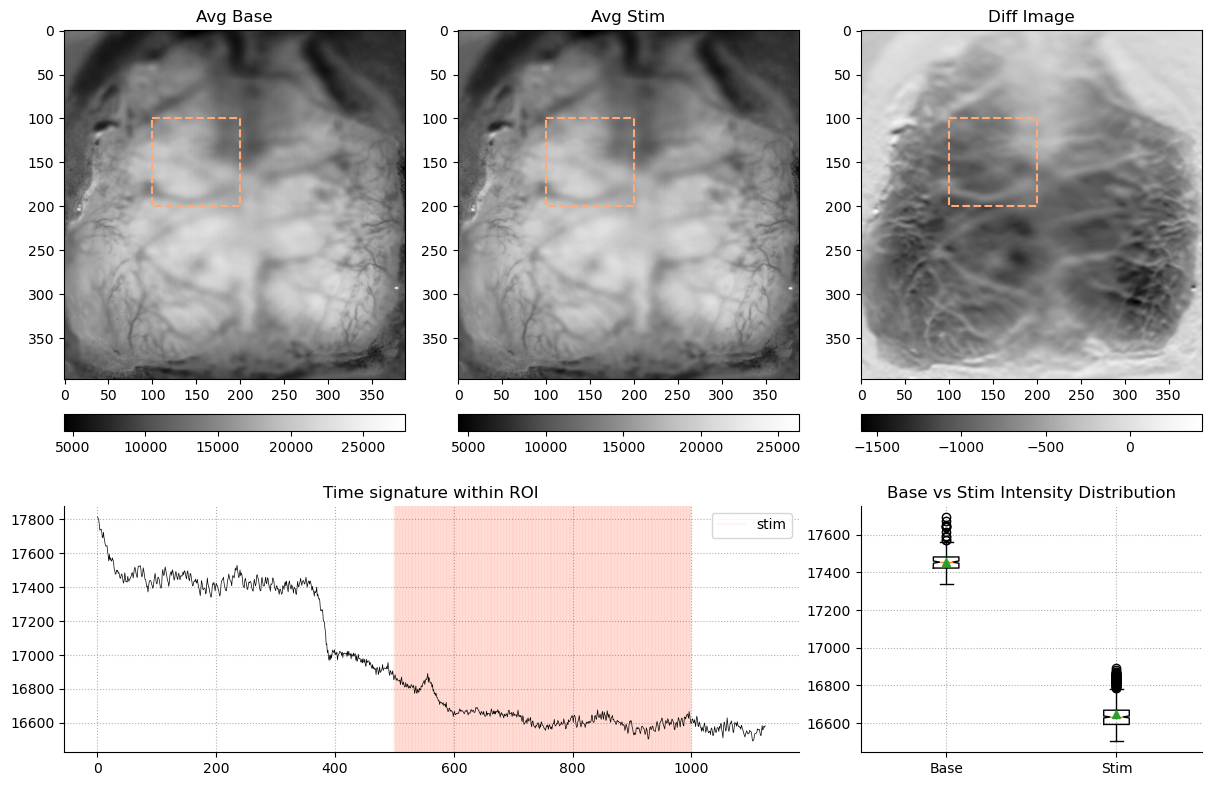

In [28]:
# define ROI
roi = {
    "center": (150, 150),  # (x, y)
    "width": 100,
    "height": 100
}

# make a fancy plot
fancy_plot(
    stack,
    frames_base,
    frames_stim,
    images,
    roi,
)